# 创建多体仿真
有关如何运行本教程笔记本的说明，请参见 [索引](./index.ipynb)。


本教程提供了一些工具，帮助你创建可以被Drake的多体物理引擎（MultibodyPlant）和几何引擎（SceneGraph）解析的场景描述文件。

## 场景文件格式：URDF、SDFormat 和 MuJoCo XML


在 Drake 中用于创建多体场景的最重要的格式是 [统一机器人描述格式（URDF）](http://wiki.ros.org/urdf)、[仿真描述格式（SDFormat）](http://sdformat.org/) 和 [MuJoCo XML (MJCF)](https://mujoco.readthedocs.io/en/stable/XMLreference.html)。这些都是用于描述机器人或对象的 XML 格式，适用于机器人仿真器或可视化。有关每种格式当前支持情况的文档，请参见 [Doxygen](https://drake.mit.edu/doxygen_cxx/group__multibody__parsing.html)。


从高层次来看，你可以用 `<link>` 标签表达机器人不同的组件，并通过 `<joint>` 标签将它们连接起来。每个 `<link>` 有三个主要子标签，分别是 `<visual>`、`<collision>` 和 `<inertial>`，分别用于可视化、规划/碰撞检测和动力学。对于 `<visual>` 和 `<collision>`，你可以使用基本体（盒、球、圆柱等）或网格（.gltf 或 .obj）来表示底层几何体。


Drake 支持的每种格式的具体标签文档可以在[这里](https://drake.mit.edu/doxygen_cxx/group__multibody__parsing.html)找到。这里有一些关于 [URDF](http://wiki.ros.org/urdf/Tutorials/Building%20a%20Visual%20Robot%20Model%20with%20URDF%20from%20Scratch) 和 [SDFormat](https://classic.gazebosim.org/tutorials?tut=build_model) 的有用资源。


### URDF 与 SDFormat


虽然 URDF 是 ROS 中的标准格式，但它缺少许多描述更复杂场景的功能。例如，URDF 只能指定单个机器人的运动学和动力学属性，不能指定关节回路和摩擦属性，也不能描述非机器人对象，如灯光、高程图等。


SDFormat 诞生于解决 URDF 的不足。SDFormat 能够完整描述从世界级别到机器人级别的一切。这种可扩展性使其更适合复杂仿真。


本教程主要聚焦于 SDFormat，但使用 URDF 时只需做一些语法上的调整。


### 网格文件格式


你可以为任何 `<link>` 使用网格文件。Drake 支持的文件格式及其支持情况见[这里](https://drake.mit.edu/doxygen_cxx/group__geometry__file__formats.html)。一般来说，glTF（`.gltf`）是 Drake 中可视化的首选格式，OBJ（`.obj`）也是很好的选择。如果你有其他格式，可以用开源软件 [Meshlab](https://www.meshlab.net/) 转换为 `.obj`。

In [1]:
# 导入本教程所需的基础库和函数。
import numpy as np
import os

from pydrake.common import temp_directory
from pydrake.geometry import SceneGraphConfig, StartMeshcat
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer

In [2]:
# 启动可视化工具。执行后该单元会输出一个 HTTP 链接。
# 点击该链接，浏览器中会打开 MeshCat 标签页。
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## 查看模型


*请确保你已在浏览器中打开 MeshCat 标签页；链接显示在上方。*


Drake 提供了 `ModelVisualizer` 类用于交互式可视化模型。当我们开始制作自己的机器人描述文件，或从其他仿真器移植描述文件时，这个类会很有帮助。下面的单元格展示了如何用 Drake 提供的预置模型进行可视化。


每运行完下面的两个示例单元格后，切换到 MeshCat 标签页即可看到机器人。点击 **Open Controls** 展开控制面板，尝试调整滑块，观察机器人运动学的变化。


在控制面板中，展开 **▶ Scene / ▶ drake** 菜单。默认只显示“illustration”几何体（Drake 对可视化几何体的称呼）。勾选“proximity”可显示碰撞几何体（红色），勾选“inertia”可显示每个刚体的等效惯性椭球体（蓝色）。使用 α 滑块调整几何体透明度。调试仿真时，记得关注这些额外视图；通常，仅靠可视化几何体无法反映动力学的全部信息。

In [ ]:
# 首先我们选择 Drake 的一个示例模型文件：KUKA iiwa 机械臂。
iiwa7_model_url = (
    "package://drake_models/iiwa_description/sdf/"
    "iiwa7_with_box_collision.sdf")

# 创建模型可视化器并添加机械臂模型。
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModels(url=iiwa7_model_url)

# 如果该笔记本在测试模式下运行，需要在无用户交互时自动停止。
# 交互式模型可视化时通常不需要 'loop_once' 参数。
test_mode = True if "TEST_SRCDIR" in os.environ else False

# 启动交互式可视化器。
# 在 MeshCat 中点击“Stop Running”按钮结束可视化。
visualizer.Run(loop_once=test_mode)

INFO:drake:Click 'Stop Running' or press Esc to quit


In [ ]:
# 再选择一个 Drake 的示例模型文件：Schunk WSG 夹爪。
schunk_wsg50_model_url = (
    "package://drake_models/wsg_50_description/sdf/"
    "schunk_wsg_50_with_tip.sdf")

# 创建新的模型可视化器并添加夹爪模型。
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModels(url=schunk_wsg50_model_url)

# 启动交互式可视化器。
# 在 MeshCat 中点击“Stop Running”按钮结束可视化。
visualizer.Run(loop_once=test_mode)

INFO:drake:Click 'Stop Running' or press Esc to quit


## 创建自定义模型


除了加载 Drake 内置的 SDFormat 文件外，你还可以在本教程中创建自己的 SDFormat 模型并进行可视化。数据可以来自文件，也可以直接用字符串。


我们可以创建一个非常简单的 SDFormat，其中包含一个带有单个 link 的模型。在 link 内部，我们声明质量和惯性属性，并用一个圆柱体作为可视化和碰撞几何体。


你可以修改下面的代码片段，改变圆柱体的尺寸或材质属性。

In [ ]:
# 定义一个简单的圆柱体模型。
cylinder_sdf = """<?xml version=\"1.0\"?>
<sdf version=\"1.7\">
  <model name=\"cylinder\">
    <pose>0 0 0 0 0 0</pose>
    <link name=\"cylinder_link\">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name=\"collision\">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>0.2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name=\"visual\">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>0.2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
  </model>
</sdf>
"""

除了 `AddModels` 方法外，`ModelVisualizer` 类还可以访问其 `Parser` 对象；你可以通过完整的解析器 API 添加模型，例如从我们刚刚创建的字符串缓冲区加载模型。

In [ ]:
# 可视化刚刚定义的 SDFormat 字符串中的圆柱体模型。
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModelsFromString(cylinder_sdf, "sdf")

# 在 MeshCat 中点击“Stop Running”按钮结束可视化。
visualizer.Run(loop_once=test_mode)

INFO:drake:Click 'Stop Running' or press Esc to quit


### 可视化与碰撞几何体


在 KUKA 机械臂示例中，如果你多次切换 MeshCat 控制面板中的 `drake/proximity` 复选框，会看到包裹 KUKA 机械臂的红色盒子出现和消失。这些就是在 `iiwa7_with_box_collision.sdf` 中定义的碰撞几何体，通常被运动规划或碰撞检测模块使用。


虽然我们可以用同一个网格表示可视化和碰撞几何体，但用基本体近似复杂网格（如 KUKA 机械臂）可以大大减少计算量。判断两个圆柱体是否碰撞比判断两个不规则网格要容易得多。因此，我们通常用网格作为可视化几何体，而用各种基本体作为碰撞几何体。


### 为你的模型定义碰撞几何体


碰撞几何体只是对实际形状的近似，我们希望这种近似尽量贴合实际，但又不要过于膨胀。例如，与其用一个大盒子包住 L 形模型，不如用两个盒子或圆柱体更好地近似形状。


这需要在近似精度和计算效率之间权衡。可以先用粗略近似，观察仿真中是否有异常（如明明没碰撞却检测到碰撞），再逐步优化。


### 用 SDFormat 包裹网格文件


你可能有一个物体的网格文件，想把它加入仿真。最简单的方法是直接将 OBJ 文件传给 `Parser.AddModels`，此时会采用默认的缩放、质量等参数。


如果默认参数不够用，你应该创建一个 SDFormat 包裹文件，指定额外属性（质量、惯性、缩放、顺应性等），然后加载该文件。你可以用 [pydrake.multibody.mesh_to_model](https://drake.mit.edu/pydrake/pydrake.multibody.mesh_to_model.html) 命令行工具生成一个基础 SDFormat 文件，再进一步自定义。


另一个有趣的新工具是 [obj2mjcf](https://github.com/kevinzakka/obj2mjcf/)，它也能处理网格。Drake 可以加载 MuJoCo XML 文件，但目前对 MuJoCo 文件格式的支持还不够完善，可能需要手动调整。


### 用网格作为碰撞几何体


有时你需要为仿真提供详细的碰撞几何体，例如对不规则物体进行灵巧操作时，可以直接用网格作为碰撞几何体。


当 OBJ 网格作为基本接触模型（点接触模型）的碰撞几何体时，Drake 会自动计算其凸包并使用。如果需要非凸碰撞几何体，建议用凸分解工具将网格分解为多个凸形状。常用的工具有 [V-HACD](https://github.com/kmammou/v-hacd/)，[convex_decomp_to_sdf](https://github.com/gizatt/convex_decomp_to_sdf) 是我们常用的 Drake 包装器。


对于更复杂的接触模型（如 hydroelastic 接触），Drake 可以直接利用实际网格进行接触力计算。详见 [Hydroelastic 用户指南](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)。

### Drake 对 SDFormat/URDF 的扩展


希望你现在已经清楚如何在 Drake 中通过 MeshCat 创建、加载和可视化基本的 SDFormat 和 URDF 模型。


在 Drake 中，我们通过添加自定义标签扩展了 URDF 和 SDFormat，以支持 Drake 特有的功能。下面的例子中，在 `collision` 标签下添加了 `drake:compliant_hydroelastic` 自定义标签，用于声明特定几何体的接触模型。另一方面，部分格式中的某些特性 Drake 的解析器并不支持，解析时会发出警告、忽略，或两者兼有。


这是更高级的话题，完整支持和不支持的标签列表请查阅 [Drake 文档](https://drake.mit.edu/doxygen_cxx/group__multibody__parsing.html)。


```

<link name="example_link">

  <inertial>

    ...

  </inertial>

  <visual name="example_visual">

    ...

  </visual>

  <collision name="example_collision">

    <pose>0 0 0 0 0 0</pose>

    <geometry>

      ...

    </geometry>

    <drake:proximity_properties>

      ...

      <drake:compliant_hydroelastic/>

    </drake:proximity_properties>

  </collision>

</link>

```

## 创建（或移植）包含多个机器人/物体的“场景”


最后，我们来看一个更真实的仿真场景，包含多个物体相互作用。在仿真中，我们将加载三个物体：一个 Drake 自带的饼干盒，以及本教程自定义的圆柱体和桌子。


仿真开始时，两个物体被放置在一定高度，然后在重力作用下自由落到桌面上。


### 创建简化版桌子


这与上面的圆柱体示例类似，但这里我们将 XML 内容保存为 SDFormat 文件，以便在仿真中使用。

In [ ]:
# 创建一个 Drake 临时目录用于存储文件。
# 注意：本教程会在 `/tmp/robotlocomotion_drake_xxxxxx` 目录下创建一个临时文件（table_top.sdf）。
temp_dir = temp_directory()

# 创建桌面 SDFormat 模型。
table_top_sdf_file = os.path.join(temp_dir, "table_top.sdf")
table_top_sdf = """<?xml version=\"1.0\"?>
<sdf version=\"1.7\">
  <model name=\"table_top\">
    <link name=\"table_top_link\">
      <visual name=\"visual\">
        <pose>0 0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>0.55 1.1 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 1.0</diffuse>
        </material>
      </visual>
      <collision name=\"collision\">
        <pose>0 0 0.445  0 0 0</pose>
        <geometry>
          <box>
            <size>0.55 1.1 0.05</size>
          </box>
        </geometry>
      </collision>
    </link>
    <frame name=\"table_top_center\">
      <pose relative_to=\"table_top_link\">0 0 0.47 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

with open(table_top_sdf_file, "w") as f:
    f.write(table_top_sdf)

### Drake 术语解释


在 Drake 中，[`System`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_system.html) 是具有输入/输出端口的基本构件，可以与其他 System 连接。例如 MultibodyPlant 和 SceneGraph 都是 System。[`Diagram`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram.html) 用于表示由多个 System 互连组成的元系统。


每个 System 和 Diagram 都有自己的 [`Context`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_context.html) 表示其状态，仿真过程中会不断更新。


Context 和 Diagram 是仿真所需的全部信息。只要 Diagram 的 Context 相同，仿真就是完全确定且可复现的。


更多相关内容请参考 [建模动力系统](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb)。


*注意：Drake 主要使用 [Doxygen C++ 文档](https://drake.mit.edu/doxygen_cxx/index.html) 作为 API 文档，同时也为 Python 用户提供了 [Python API 文档](https://drake.mit.edu/pydrake/)。*


### 向“场景”中加载不同物体


在 `create_scene()` 函数中，我们首先创建 `pydrake.multibody.MultibodyPlant`、`pydrake.multibody.SceneGraph` 和 `pydrake.multibody.parsing.Parser`。


解析器用于将模型加载到 MultibodyPlant。本例中需要注意的是，我们将桌子与世界焊接（固定），而将饼干盒和圆柱体作为自由体处理。MultibodyPlant 设置好后，函数返回一个 Diagram，供 Drake Simulator 使用（此处用默认 context）。

In [ ]:
def create_scene(sim_time_step):
    # 清理 Meshcat 实例。
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=sim_time_step)
    parser = Parser(builder)

    # 加载模型。
    # 加载我们创建的桌面和圆柱体模型。
    parser.AddModelsFromString(cylinder_sdf, "sdf")
    parser.AddModels(table_top_sdf_file)
    # 加载 Drake 自带的饼干盒模型。
    parser.AddModels(
        url="package://drake_models/ycb/003_cracker_box.sdf")
    # 直接加载 Drake 的 OBJ 文件，无需 SDFormat 包裹文件。此时质量和惯性将根据网格体积（假设为水）自动推断，网格同时用于碰撞和可视化几何体。
    parser.AddModels(
        url="package://drake_models/ycb/meshes/004_sugar_box_textured.obj")

    # 将桌子焊接到世界，使其在仿真过程中保持固定。
    table_frame = plant.GetFrameByName("table_top_center")
    plant.WeldFrames(plant.world_frame(), table_frame)  
    # 加载场景后，完成 plant 的设置。
    plant.Finalize()
    # 使用默认 context 计算桌子在世界坐标系下的变换，但这不是 Diagram 消耗的 context。
    plant_context = plant.CreateDefaultContext()

    # 设置自由体（自定义圆柱体、饼干盒、糖盒）的初始位姿。
    cylinder = plant.GetBodyByName("cylinder_link")
    X_WorldTable = table_frame.CalcPoseInWorld(plant_context)
    X_TableCylinder = RigidTransform(
        RollPitchYaw(np.asarray([90, 0, 0]) * np.pi / 180), p=[0,0,0.5])
    X_WorldCylinder = X_WorldTable.multiply(X_TableCylinder)
    plant.SetDefaultFreeBodyPose(cylinder, X_WorldCylinder)

    cracker_box = plant.GetBodyByName("base_link_cracker")
    X_TableCracker = RigidTransform(
        RollPitchYaw(np.asarray([45, 30, 0]) * np.pi / 180), p=[0,0,0.8])
    X_WorldCracker = X_WorldTable.multiply(X_TableCracker)
    plant.SetDefaultFreeBodyPose(cracker_box, X_WorldCracker)

    sugar_box = plant.GetBodyByName("004_sugar_box_textured")
    X_TableSugar = RigidTransform(p=[0,-0.25,0.8])
    X_WorldSugar = X_WorldTable.multiply(X_TableSugar)
    plant.SetDefaultFreeBodyPose(sugar_box, X_WorldSugar)
    
    # 添加可视化以显示几何体。
    AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()
    return diagram

## 运行简单仿真


我们已经准备好启动仿真器了！运行下面的代码块，在 MeshCat 标签页中可视化仿真。


这个简单仿真是一个无源系统，物体仅受重力作用自由下落。结果是否符合你的预期？你还可以在 MeshCat 标签页中使用 **reset** 和 **play** 按钮重新运行仿真。


尝试调整 `sim_time_step` 并重新运行仿真。建议先用较小的值，然后逐步增大，观察行为是否有变化。

In [ ]:
def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    return simulator

def run_simulation(sim_time_step):
    diagram = create_scene(sim_time_step)
    simulator = initialize_simulation(diagram)
    meshcat.StartRecording()
    finish_time = 0.1 if test_mode else 2.0
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()

# 用较小的时间步长运行仿真。可以尝试逐步增大该值！
run_simulation(sim_time_step=0.0001)

## 快速预览 hydroelastic 接触


只需稍作配置修改，我们就可以用 hydroelastic 接触模型对所有物体进行仿真，无需编辑模型文件。这种方法为所有物体应用了合理的默认值，但未必适合特定场景。要获得更精细的控制，需要编辑模型文件。更多信息请参见 [hydroelastic 接触基础](http://localhost:8888/notebooks/hydroelastic_contact_basics.ipynb) 教程。

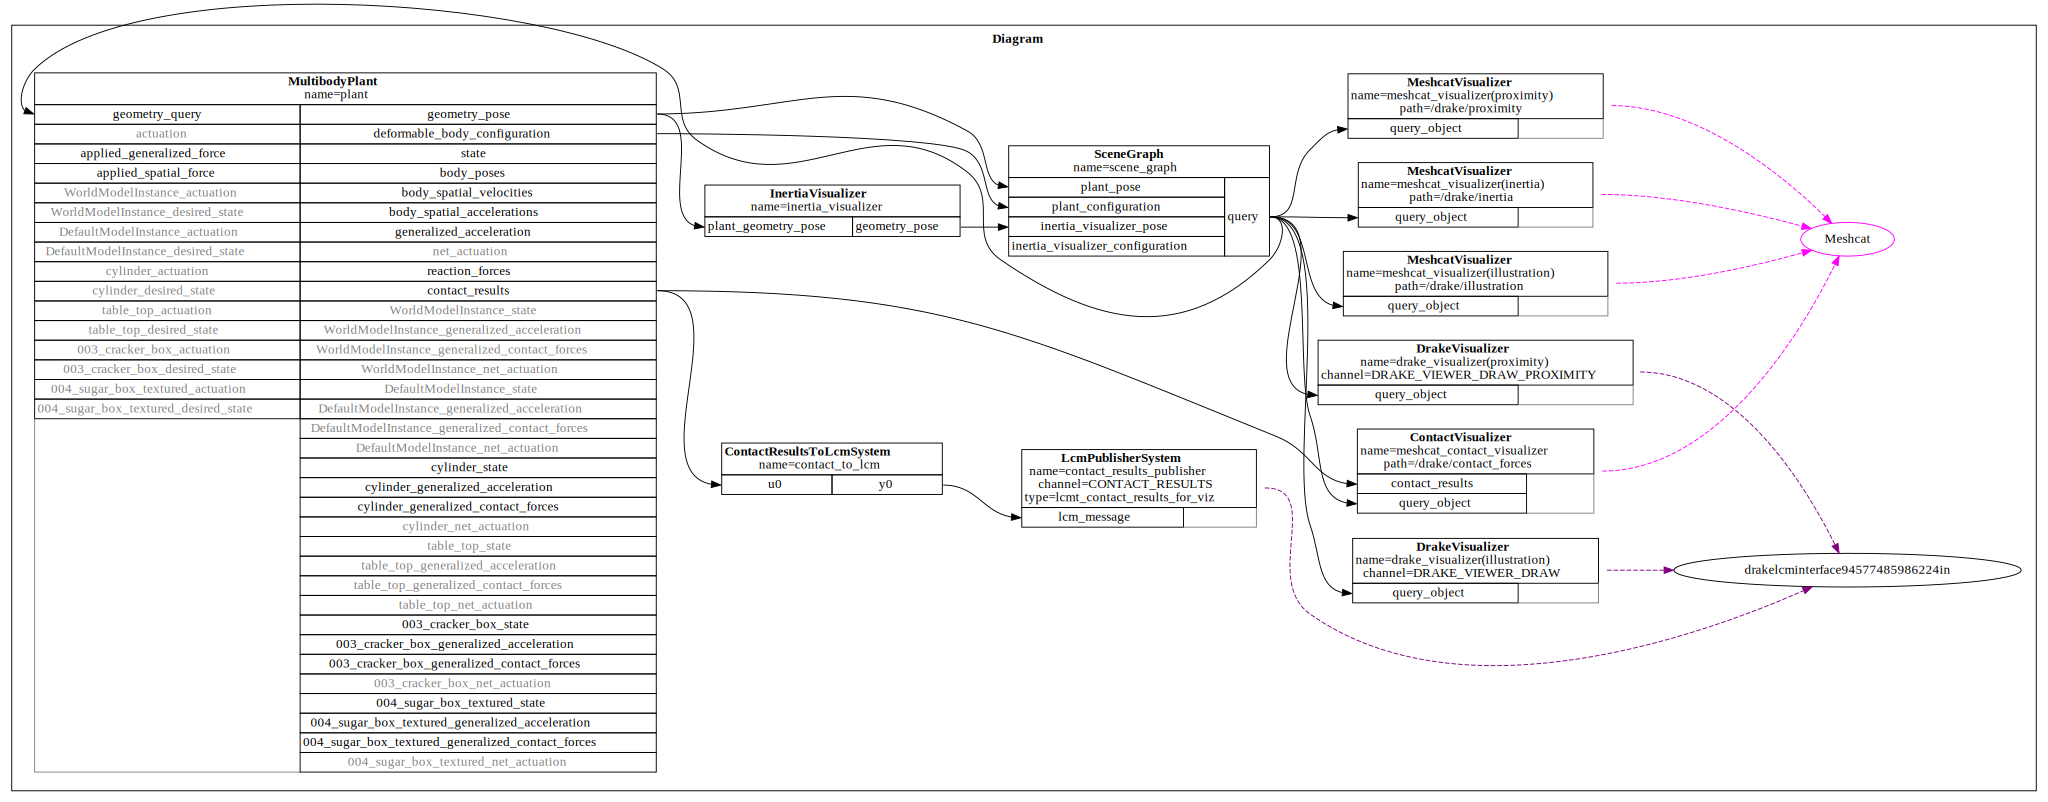

In [ ]:
from pydrake.systems.drawing import plot_system_graphviz
def run_all_hydroelastic_simulation(sim_time_step):
    diagram = create_scene(sim_time_step)
    plot_system_graphviz(diagram, max_depth=3)
    
    # SceneGraphConfig 允许我们为所有物体统一修改默认的接触属性。
    scene_graph = diagram.GetSubsystemByName("scene_graph")
    config = SceneGraphConfig()
    config.default_proximity_properties.compliance_type = "compliant" # 使用柔性接触
    config.default_proximity_properties.hunt_crossley_dissipation = 1.0 # 接触阻尼
    scene_graph.set_config(config)
    
    simulator = initialize_simulation(diagram)
    meshcat.StartRecording()
    finish_time = 0.1 if test_mode else 2.0
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()

# 运行仿真，与上面类似。注意此时接触物理已不同，接触力箭头变为红色而非绿色。
run_all_hydroelastic_simulation(sim_time_step=0.002)

## 调试你的 MultibodyPlant/SceneGraph


有时仿真结果会出乎意料，例如物理行为异常或程序崩溃，通常是因为仿真设置与真实物理属性不符。


### 调试惯性属性


常见问题之一是部分物体缺少惯性属性，导致仿真步长极小（如 < 0.001s），或出现 `Delta > 0` 错误，或惯性矩阵无效的警告。


请务必检查惯性属性，尤其是关注动力学行为时。可通过 `ModelVisualizer` 的惯性可视化层直观查看。在控制面板 `Scene >> drake` 下勾选 `inertia` 复选框。


要自动计算 URDF 或 SDFormat 模型的惯性，可尝试 [fix_inertia](https://drake.mit.edu/pydrake/pydrake.multibody.fix_inertia.html) 工具。


### 调试质量属性


如果物体被焊接到世界，则无需指定质量。但如果可移动物体质量为零，会触发错误，说明仿真尚未完全指定。


提示：可移动物体的质量/惯性是否合理？尝试修改并重新运行仿真，观察变化。

## 后续学习建议


本教程帮助你搭建了物理引擎（MultibodyPlant）和几何引擎（SceneGraph），并在 MeshCat 中可视化仿真。但大多数机器人仿真还需要更多内容。接下来，你可能需要建模传感器、底层控制系统，甚至高层感知、规划和控制系统。


以下资源可供进一步学习：


- [Drake MultibodyPlant](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html)

- [Drake SceneGraph](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_scene_graph.html)

- [Drake 拾取放置机器人基础教程](https://manipulation.csail.mit.edu/pick.html)

- [hydroelastic 接触基础教程](./hydroelastic_contact_basics.ipynb)